# Nonparametric methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Nonparametric Density Estimation

Text(0.5, 1.0, 'poisson')

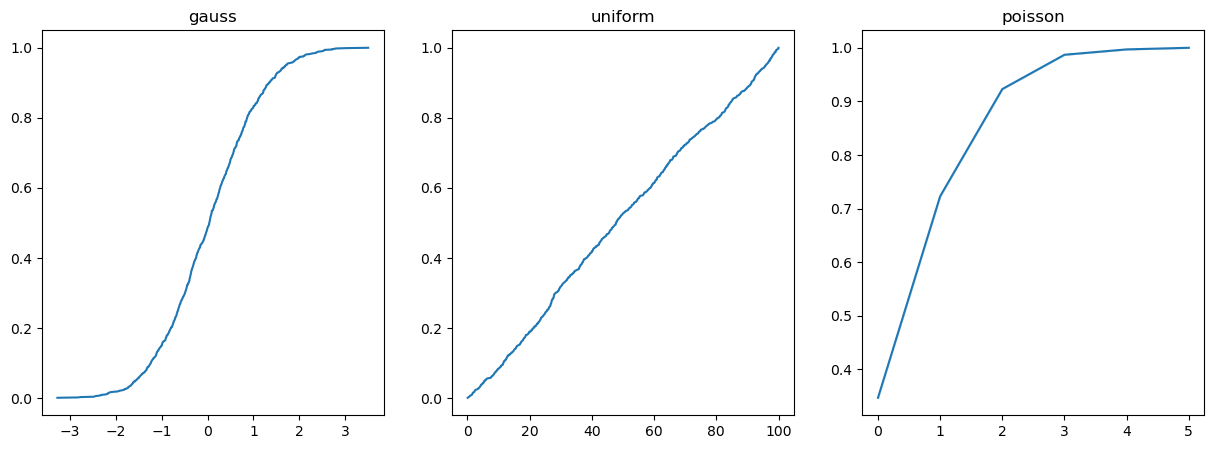

In [128]:
cdf = lambda x: np.sum(x <= x[..., None], axis=1)/x.shape[0]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

x_gauss = np.random.normal(0, 1, size=(1000,))
x_unifo = np.random.uniform(0, 100, size=(1000,))
x_poiss = np.random.poisson(1, size=(1000,))

sns.lineplot(x=x_gauss, y=cdf(x_gauss), ax=axes[0])
sns.lineplot(x=x_unifo, y=cdf(x_unifo), ax=axes[1])
sns.lineplot(x=x_poiss, y=cdf(x_poiss), ax=axes[2])
axes[0].set_title("gauss")
axes[1].set_title("uniform")
axes[2].set_title("poisson")

(0.0, 1.0)

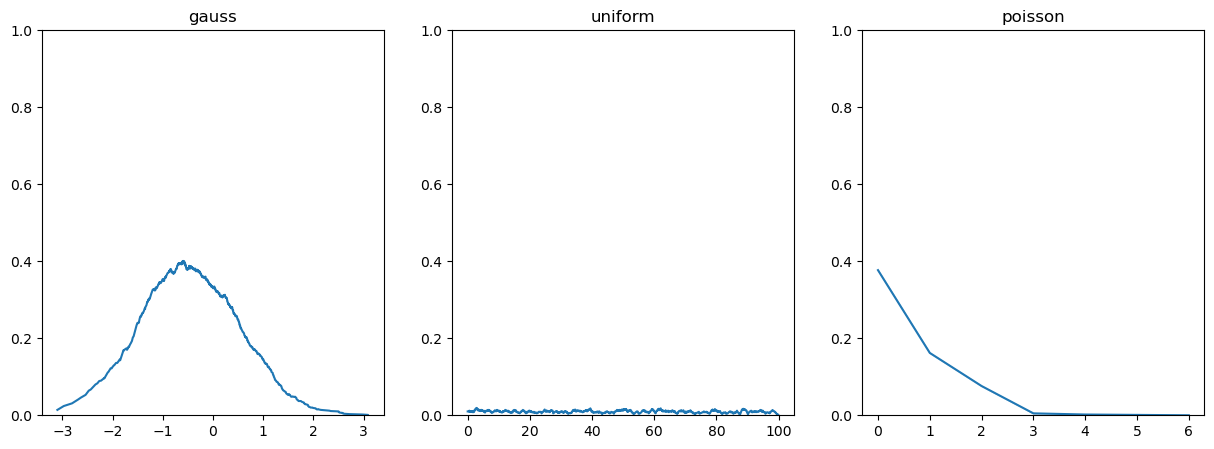

In [127]:
pdf = lambda x, h: 1/h * ((np.sum(x <= (x[..., None] + h), axis=1) - np.sum(x <= x[..., None], axis=1))/x.shape[0])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

h = 1

sns.lineplot(x=x_gauss, y=pdf(x_gauss, h), ax=axes[0])
sns.lineplot(x=x_unifo, y=pdf(x_unifo, h), ax=axes[1])
sns.lineplot(x=x_poiss, y=pdf(x_poiss, h), ax=axes[2])
axes[0].set_title("gauss")
axes[1].set_title("uniform")
axes[2].set_title("poisson")

axes[0].set_ylim((0, 1))
axes[1].set_ylim((0, 1))
axes[2].set_ylim((0, 1))

### Histogram estimator

Interval:
$$
    [x_o + mh, x_o + (m+1)h]
$$
estimate:
$$
    \hat{P}(x) = \dfrac{\#\{x^t \text{ in the same bin as } x\}}{Nh}
$$

In [142]:
import math

def hist_intervals(xo, h, minm, maxm):
    return [(xo + m * h, xo + (m+1) * h) for m in range(math.floor(minm), math.ceil(maxm))]

hist_intervals(0, 1, -5, 5)

[(-5, -4),
 (-4, -3),
 (-3, -2),
 (-2, -1),
 (-1, 0),
 (0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5)]

{(-9.959201987667903, -9.859201987667904): 0, (-9.859201987667904, -9.759201987667904): 0, (-9.759201987667904, -9.659201987667904): 0, (-9.659201987667904, -9.559201987667905): 0, (-9.559201987667905, -9.459201987667903): 0, (-9.459201987667903, -9.359201987667904): 0, (-9.359201987667904, -9.259201987667904): 0, (-9.259201987667904, -9.159201987667904): 0, (-9.159201987667904, -9.059201987667903): 0, (-9.059201987667903, -8.959201987667903): 0, (-8.959201987667903, -8.859201987667904): 0, (-8.859201987667904, -8.759201987667904): 0, (-8.759201987667904, -8.659201987667904): 0, (-8.659201987667904, -8.559201987667903): 0, (-8.559201987667903, -8.459201987667903): 0, (-8.459201987667903, -8.359201987667904): 0, (-8.359201987667904, -8.259201987667904): 0, (-8.259201987667904, -8.159201987667904): 0, (-8.159201987667904, -8.059201987667903): 0, (-8.059201987667903, -7.959201987667904): 0, (-7.959201987667904, -7.8592019876679045): 0, (-7.8592019876679045, -7.759201987667905): 0, (-7.759

<BarContainer object of 200 artists>

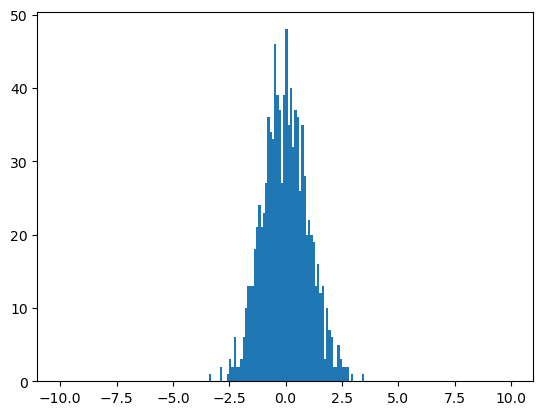

In [245]:
def create_hist(x: np.ndarray, bins):
    minm = x.min()
    maxm = x.max()
    mean = x.mean()
    counter = {
        (l, u): np.where((x <= u) & (x >= l), 1, 0).sum() 
        for (l, u) in hist_intervals(mean, bins, -100, 100)
    }
    
    print(counter, minm, maxm)
    return counter

y = create_hist(x_gauss, 0.1)
width = [u-l for (l, u) in y.keys()]
x = [l for (l, _) in y.keys()]
vals = [v for v in y.values()]

plt.bar(x, width=width, height=vals)


<BarContainer object of 1000 artists>

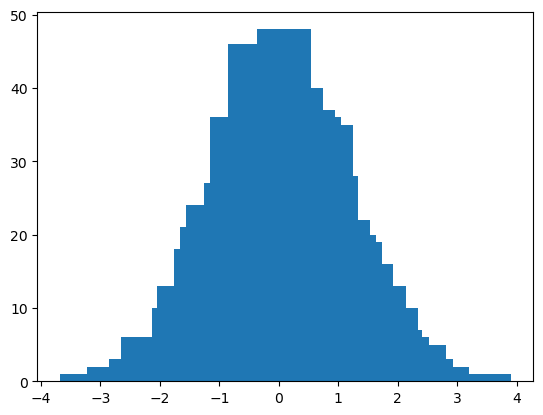

In [246]:
hist_p = lambda x, counter: [v for (l, u), v in counter.items() if l <= x <= u]

p = np.array([hist_p(xi, y) for xi in x_gauss])

plt.bar(x_gauss, p[:, 0])

### Naive estimator

$$
    \hat{P}(x) = \dfrac{\#\{x - h/2 < x^t \leq x + h/2\}}{Nh}
$$

<BarContainer object of 1000 artists>

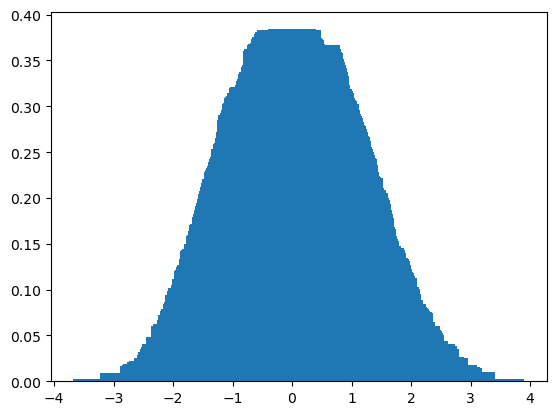

In [260]:
naive_estimator = lambda x, h: np.sum((x[..., None] - h/2 < x) & (x <= x[..., None] + h/2), axis=1)/(x.shape[0]*h)

h = 1
y = naive_estimator(x_gauss, h)

plt.bar(x_gauss, y)

Alternative formula for naive estimator
$$
    \hat{P}(x) = \frac{1}{Nh} \sum_{t=1}^N w \left(\frac{x-x^t}{h}\right)
$$
where 
$$
    w(u) \begin{cases}
        1 & \text{if $|u| < 1/2$}\\
        0 & \text{otherwise}
    \end{cases}
$$

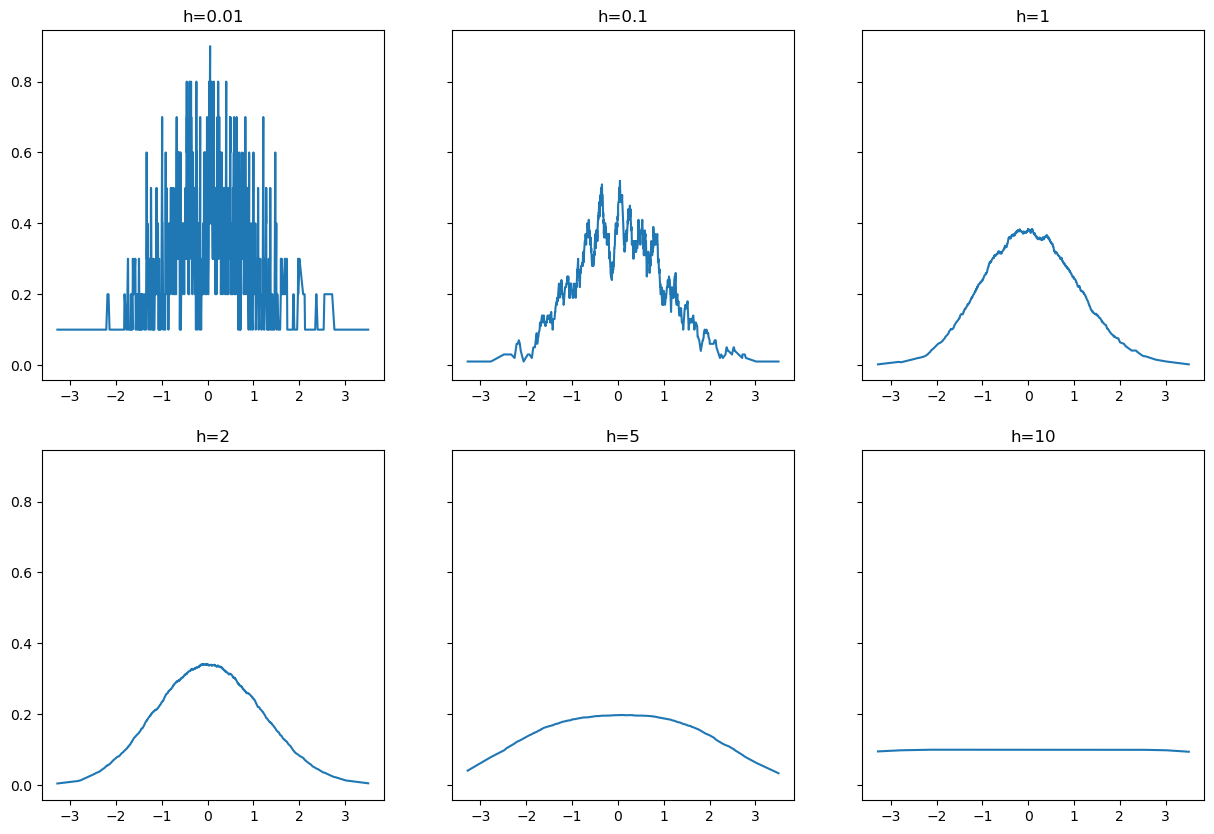

In [286]:
w = lambda x: 1*(np.abs(x) < 0.5)
naive_estimator_alt = lambda x, h: 1/(x.shape[0]*h) * np.sum(w((x[..., None] - x)/h), axis=1)

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
axes = axes.flatten()

hs = [0.01, 0.1, 1, 2, 5, 10]
for i, h in enumerate(hs):
    y = naive_estimator_alt(x_gauss, h)
    sns.lineplot(x=x_gauss, y=y, ax=axes[i])
    axes[i].set_title(f"{h=}")

### Kernel Estimator

$$
    \hat{P}(x) = \frac{1}{Nh} \sum_{t=1}^N K \left(\frac{x-x^t}{h}\right)
$$
where 
$$
    K(u) = \frac{1}{\sqrt{2\pi}} \exp{\left[-\frac{u^2}{2}\right]}
$$

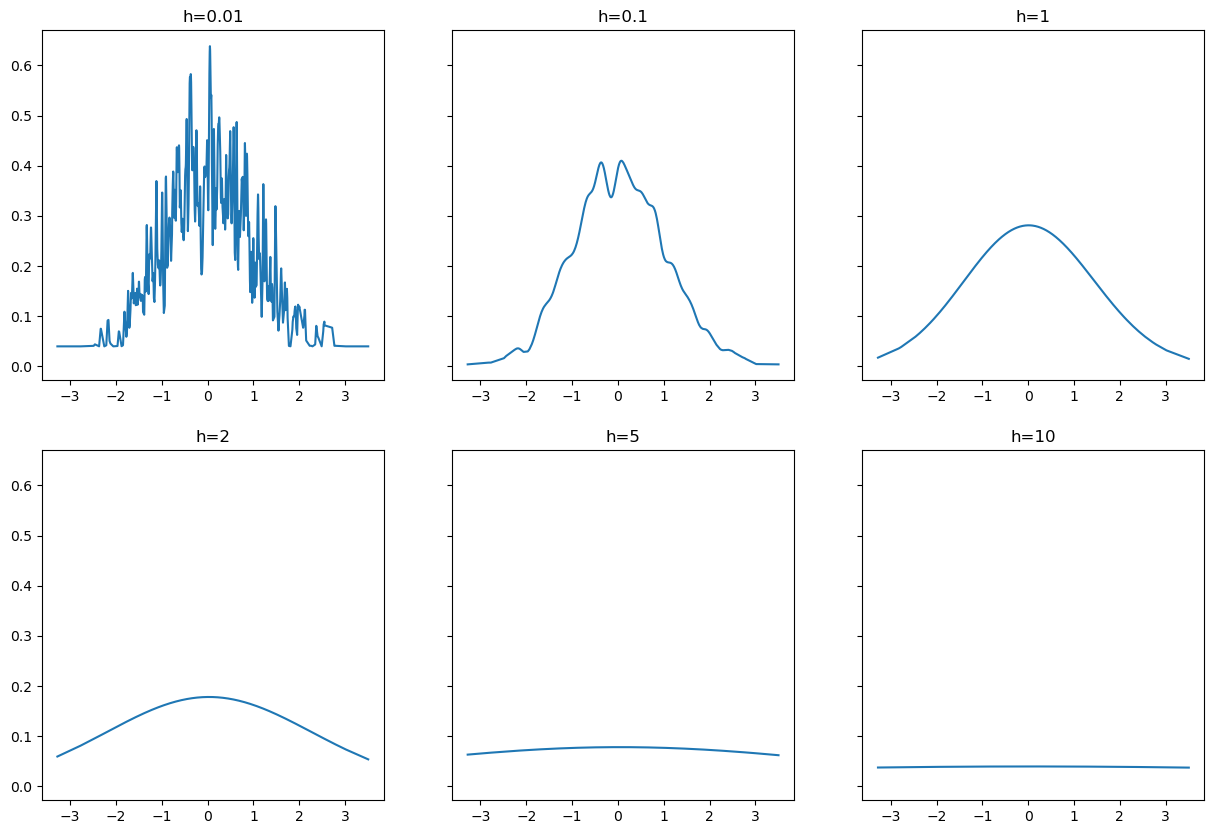

In [292]:
k = lambda x: 1/np.sqrt(2*np.pi) * np.exp(-x**2 / 2)
kernel_estimator = lambda x, h: 1/(x.shape[0]*h) * np.sum(k((x[..., None] - x)/h), axis=1)

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
axes = axes.flatten()

hs = [0.01, 0.1, 1, 2, 5, 10]
for i, h in enumerate(hs):
    y = kernel_estimator(x_gauss, h)
    sns.lineplot(x=x_gauss, y=y, ax=axes[i])
    axes[i].set_title(f"{h=}")

### K-Nearest Neighbours Estimator

In [391]:
# test univariate sample
x = np.array([1, 3, 4, 10, 13, 43, 44, 51], dtype=np.float64)

# distance metric: absolute distance
abs_diff = np.abs(x[..., None] - x)
# diagonal is |x-x| = 0, thus these are set to inf
np.fill_diagonal(abs_diff, np.inf)

# find indices of minima along axis 0 (for each column)
min_indices = abs_diff.argmin(axis=0)

# between x1 and x2 is a distance of dist
print("1-nearest neighbours:\n   x1  x2  d\n--------------")
print(np.array([(xi, x[mini], abs_diff[mini, i]) for i, (mini, xi) in enumerate(zip(min_indices, x))]))

1-nearest neighbours:
   x1  x2  d
--------------
[[ 1.  3.  2.]
 [ 3.  4.  1.]
 [ 4.  3.  1.]
 [10. 13.  3.]
 [13. 10.  3.]
 [43. 44.  1.]
 [44. 43.  1.]
 [51. 44.  7.]]


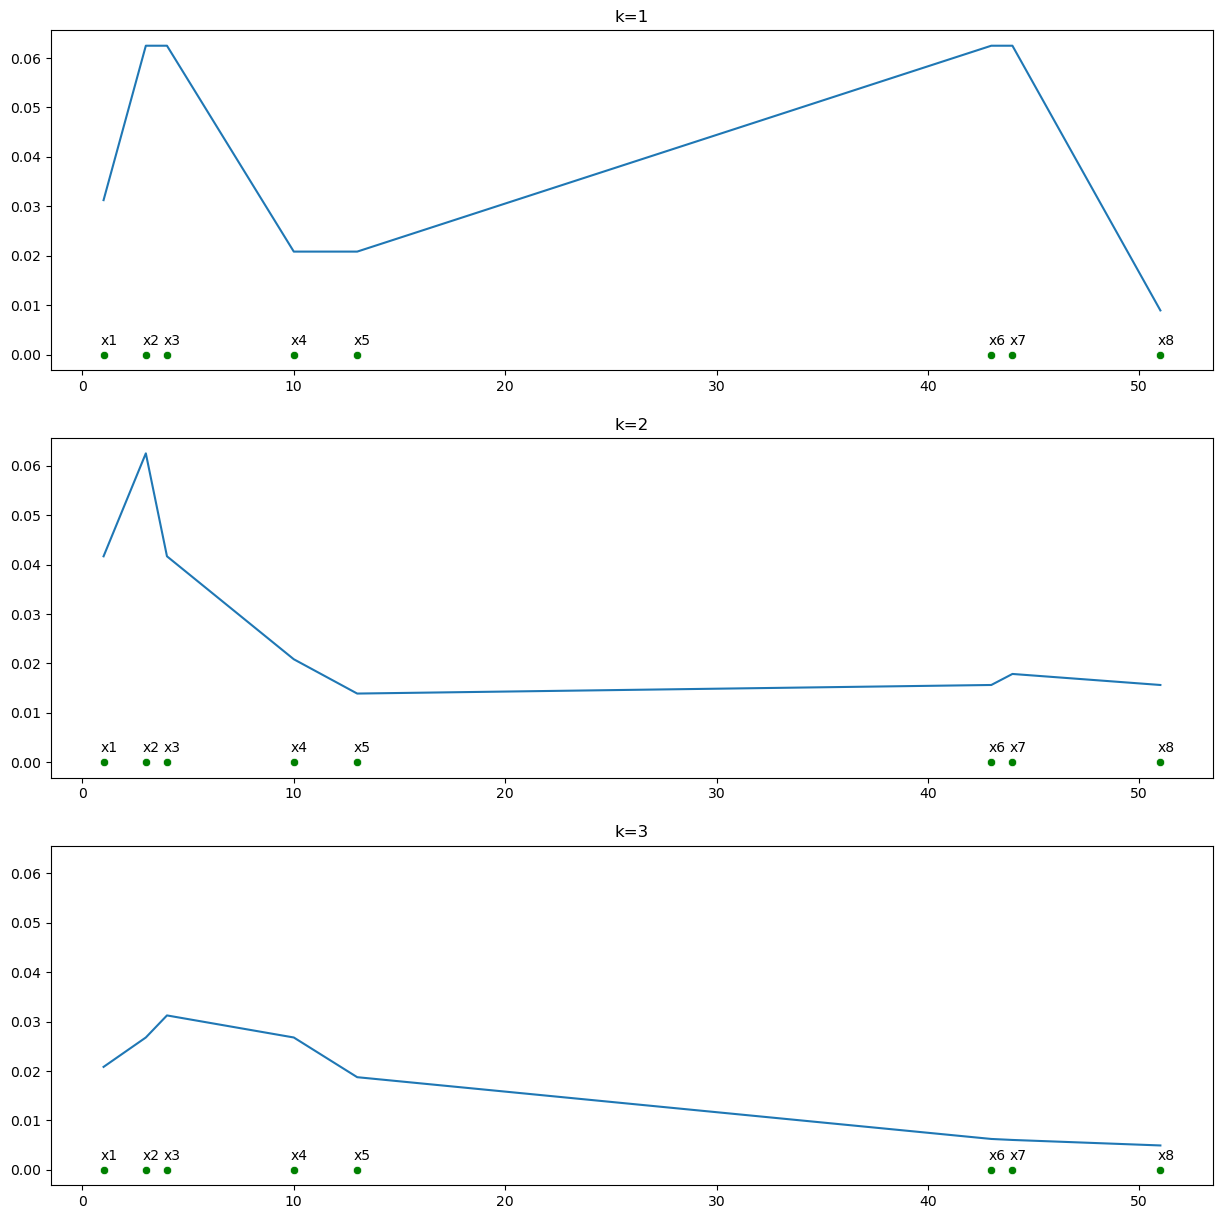

In [457]:
def knn_estimator(x: np.ndarray, k=1):

    abs_diff = np.abs(x[..., None] - x)
    np.fill_diagonal(abs_diff, np.inf)
    abs_diff.sort(axis=0)
    return k/(2*x.shape[0] * abs_diff[k-1, :])

fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharey=True)
axes = axes.flatten()

ks = [1, 2, 3]
for i, k in enumerate(ks):
    sns.scatterplot(x=x, y=np.zeros_like(x), c='g', ax=axes[i])
    sns.lineplot(x=x, y=knn_estimator(x, k), ax=axes[i])
    for xi, j in enumerate(x):
        axes[i].text(j-0.15, 0.002, f"x{xi+1}")
    axes[i].set_title(f"{k=}")

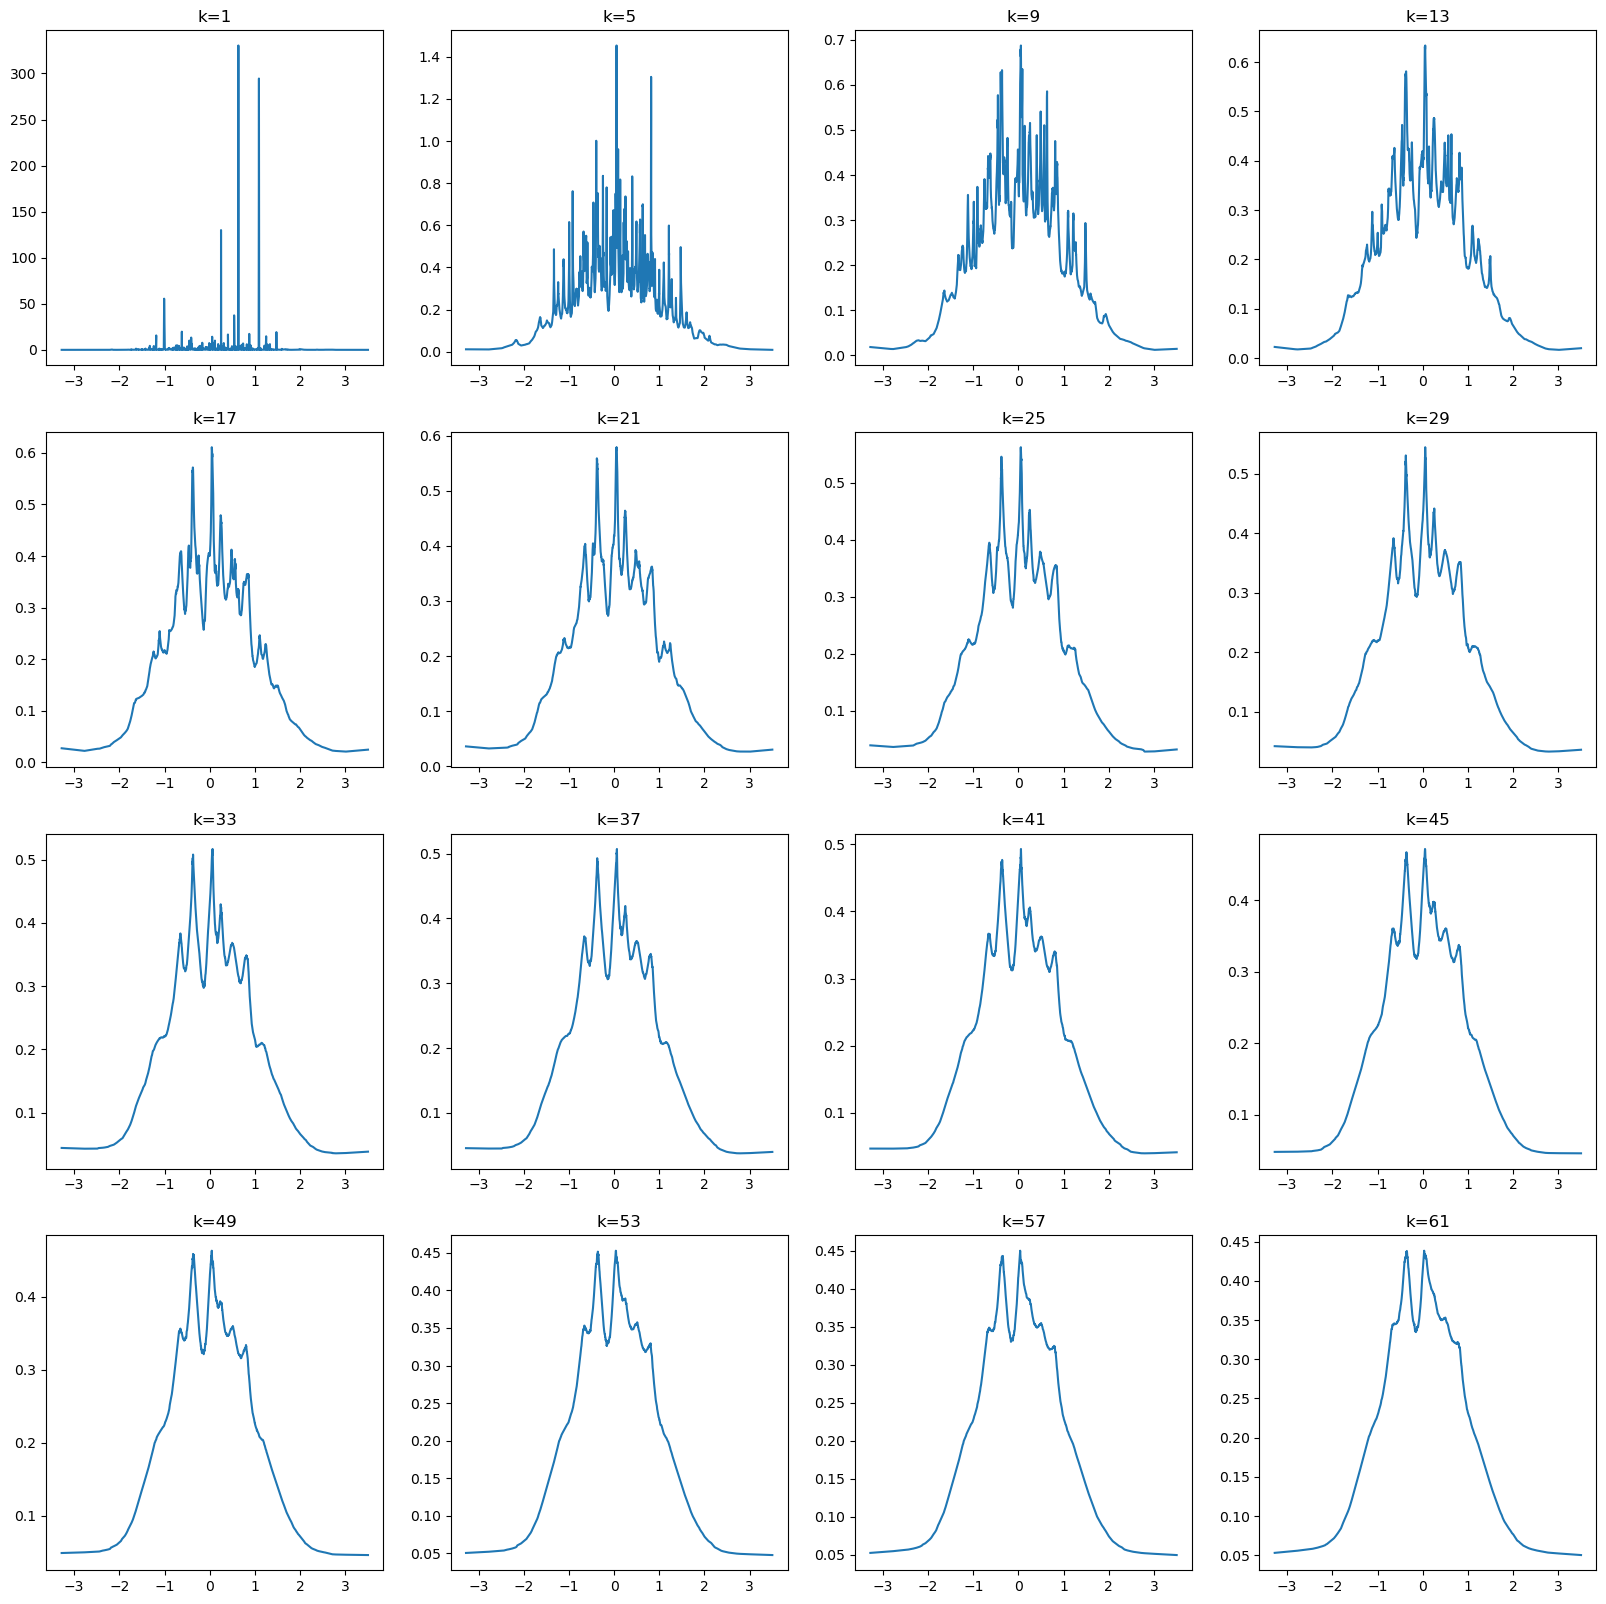

In [448]:
K = lambda x: 1/np.sqrt(2*np.pi) * np.exp(-x**2 / 2)

def kernel_knn_estimator(x: np.ndarray, k=1):

    abs_diff = np.abs(x[..., None] - x)
    np.fill_diagonal(abs_diff, np.inf)
    abs_diff.sort(axis=0)
    return 1/(x.shape[0] * abs_diff[k-1, :]) * np.sum(K((x[..., None] - x)/abs_diff[k-1, :]), axis=0)


fig, axes = plt.subplots(4, 4, figsize=(20, 20), sharey=False)
axes = axes.flatten()

ks = [1, 10, 50, 100]
for i, k in enumerate(range(1, 65, 4)):
    sns.lineplot(x=x_gauss, y=kernel_knn_estimator(x_gauss, k), ax=axes[i])
    axes[i].set_title(f"{k=}")